In [9]:
import random
from collections import deque

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# -----------------------
# 1. Define the Networks
# -----------------------
class Action(nn.Module):
    def __init__(self, state_dim, num_actions):
        super(Action, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


class Target(nn.Module):
    def __init__(self, state_dim, num_actions):
        super(Target, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [10]:
# -----------------------
# 2. Replay Buffer
# -----------------------
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, cost, next_state, done):
        self.buffer.append((state, action, cost, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, costs, next_states, dones = zip(*batch)
        return (
            np.vstack(states),
            np.array(actions),
            np.array(costs, dtype=np.float32),
            np.vstack(next_states),
            np.array(dones, dtype=np.uint8),
        )

    def __len__(self):
        return len(self.buffer)


In [11]:
# -----------------------
# 3. Environment & Cost
# -----------------------
p, a_cost, b_cost = 1, 1, 2
def inventory_cost(s_next, a):
    if s_next >= 0:
        return p * a + a_cost * s_next
    else:
        return p * a + b_cost * -s_next


In [ ]:
# -----------------------
# 4. Hyperparameters
# -----------------------
num_actions        = 3
T                  = 100
min_inventory      = -10
max_inventory      = 10
state_dim          = 2       # [inventory_level, time_step]
buffer_capacity    = 5000
batch_size         = 32
gamma              = 1
epsilon            = 0.1
target_update_freq = 100
learning_rate      = 1e-3
num_episodes       = 500




In [13]:
# -----------------------
# 5. Setup Device, Nets, Optimizer
# -----------------------
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net = Action(state_dim, num_actions).to(device)
target_net = Target(state_dim, num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

replay_buffer = ReplayBuffer(buffer_capacity)

In [ ]:
# -----------------------
# 6. Training Loop
# -----------------------
step_count = 0
policy_net.train()

for episode in range(num_episodes):
    s = random.randint(min_inventory, max_inventory)

    for t in range(T):
        # build state vector
        state = np.array([s, t], dtype=np.float32)

        # ε-greedy action selection (minimize Q)
        if random.random() < epsilon:
            a = random.randrange(num_actions)
        else:
            with torch.no_grad():
                st_v   = torch.from_numpy(state).unsqueeze(0).to(device)
                q_vals = policy_net(st_v)
                a      = q_vals.argmin(dim=1).item()

        # step environment
        w       = random.randint(0, 10)
        s_next  = s + a - w
        cost    = inventory_cost(s_next, a)
        done    = (t == T - 1)
        next_t  = t + 1 if not done else 0
        next_state = np.array([s_next, next_t], dtype=np.float32)

        # store transition
        replay_buffer.push(state, a, cost, next_state, done)
        s = s_next

        # learn if enough samples
        if len(replay_buffer) >= batch_size:
            states, actions, costs, next_states, dones = replay_buffer.sample(batch_size)

            st_v     = torch.from_numpy(states).to(device)
            nxt_st_v = torch.from_numpy(next_states).to(device)
            act_v    = torch.from_numpy(actions).long().to(device)
            cost_v   = torch.from_numpy(costs).to(device)
            done_v   = torch.from_numpy(dones).to(device)

            # compute Q(s,a)
            q_vals = policy_net(st_v)
            q_s_a  = q_vals.gather(1, act_v.unsqueeze(1)).squeeze(1)

            # compute TD target
            with torch.no_grad():
                next_q     = target_net(nxt_st_v)
                min_next_q = next_q.min(1)[0]
                target_q   = cost_v + gamma * min_next_q * (1 - done_v)

            loss = criterion(q_s_a, target_q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # sync target network
            step_count += 1
            if step_count % target_update_freq == 0:
                target_net.load_state_dict(policy_net.state_dict())

    # monitor average Q-value
    if episode % log_every == 0:
        policy_net.eval()
        sample_states = random.choices(all_states, k=num_q_samples)
        sample_times  = random.choices(all_times,  k=num_q_samples)

        st_batch = torch.tensor(
            list(zip(sample_states, sample_times)),
            dtype=torch.float32,
            device=device
        )
        with torch.no_grad():
            q_batch = policy_net(st_batch)
        avg_q = q_batch.mean().item()
        avg_q_history.append((episode, avg_q))
        print(f"[Monitor] Episode {episode:4d}: avg Q = {avg_q:.3f}")
        policy_net.train()

    if episode % 50 == 0:
        print(f"Episode {episode:4d} complete")

print("Training finished.")

# -----------------------
# 7. Plot Q-Value Convergence
# -----------------------
episodes, avg_qs = zip(*avg_q_history)
plt.figure(figsize=(8, 4))
plt.plot(episodes, avg_qs, marker='o')
plt.xlabel("Episode")
plt.ylabel("Average Q(s,t,a)")
plt.title("DQN Q-Value Convergence Over Training")
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: Sample larger than population or is negative

In [7]:
import numpy as np
import torch
import random

# ── assume these are defined from your training script ────────────────────
# policy_net, device, num_actions, T, min_inventory, max_inventory
# ─────────────────────────────────────────────────────────────────────────

# 1) Construct the Q-table: shape (num_states, T, num_actions)
num_states = max_inventory - min_inventory + 1
Q_table = np.zeros((num_states, T, num_actions), dtype=np.float32)

policy_net.eval()
with torch.no_grad():
    for idx, s in enumerate(range(min_inventory, max_inventory + 1)):
        for t in range(T):
            inp = torch.tensor([[s, t]], dtype=torch.float32, device=device)
            qvals = policy_net(inp)            # [1, num_actions]
            Q_table[idx, t, :] = qvals.cpu().numpy()

# 2) Rollout from initial (s=0, t=0) and log steps
s = 0
t = 0

print(f"{'Time':>4s} | {'Inventory':>9s} | {'Demand':>6s} | {'Action':>6s}")
print("-" * 55)
for step in range(T):
    s_idx = s - min_inventory
    # choose action that minimizes Q
    a = int(Q_table[s_idx, t, :].argmin())

    # sample demand
    w = random.randint(0, 10)

    # log
    print(f"{t:4d} | {s:9d} | {w:6d} | {a:6d}")

    # advance environment
    s = s + a - w
    # clamp back into valid range
    s = max(min_inventory, min(max_inventory, s))
    t = (t + 1) % T



Time | Inventory | Demand | Action
-------------------------------------------------------
   0 |         0 |      5 |      0
   1 |        -5 |      1 |      0
   2 |        -6 |      0 |      0
   3 |        -6 |      5 |      0
   4 |       -10 |      0 |      0
   5 |       -10 |      8 |      0
   6 |       -10 |      4 |      0
   7 |       -10 |      3 |      0
   8 |       -10 |      2 |      2
   9 |       -10 |      1 |      2
  10 |        -9 |      0 |      0
  11 |        -9 |      7 |      0
  12 |       -10 |      4 |      0
  13 |       -10 |      9 |      0
  14 |       -10 |      6 |      0
  15 |       -10 |     10 |      0
  16 |       -10 |      1 |      0
  17 |       -10 |      3 |      0
  18 |       -10 |      4 |      0
  19 |       -10 |      0 |      0
  20 |       -10 |      3 |      0
  21 |       -10 |      9 |      0
  22 |       -10 |      0 |      0
  23 |       -10 |      4 |      0
  24 |       -10 |      0 |      0
  25 |       -10 |      1 |      0

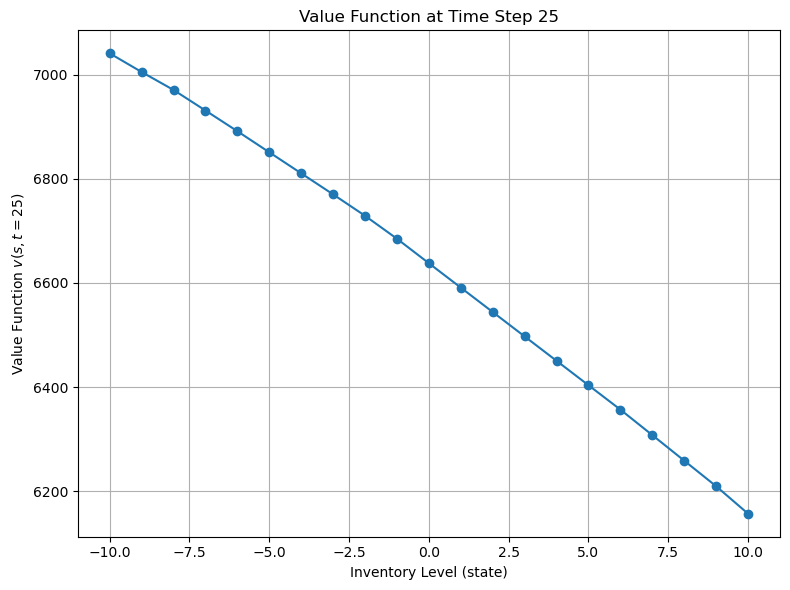

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# ── assume these are defined ────────────────────────────────────────────────
# Q_table : np.ndarray shaped (num_states, T, num_actions)
# min_inventory, max_inventory : int
# T : total number of time steps
# ────────────────────────────────────────────────────────────────────────────

# 1) Choose which time step to visualize
time_step = 25
assert 0 <= time_step < T, "time_step must be in [0, T)"

# 2) Compute value function v(s) = min_a Q(s, time_step, a)
#    Q_table[s_idx, t, a] where s_idx = s - min_inventory
v = Q_table[:, time_step, :].min(axis=1)

# 3) Build the array of actual inventory levels
states = np.arange(min_inventory, max_inventory + 1)

# 4) Plot
plt.figure(figsize=(8, 6))
plt.plot(states, v, marker='o', linestyle='-')
plt.xlabel('Inventory Level (state)')
plt.ylabel(f'Value Function $v(s, t={time_step})$')
plt.title(f'Value Function at Time Step {time_step}')
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assume Q_table, min_inventory, max_inventory, T, and loss_history are defined

# 1) Build best-action table
best_action_table = np.argmin(Q_table, axis=2)  # shape (num_states, T)
states = list(range(min_inventory, max_inventory + 1))
time_steps = list(range(T))

df_actions = pd.DataFrame(best_action_table, index=states, columns=time_steps)
import ace_tools as tools; tools.display_dataframe_to_user("Best Action per (Inventory, Time)", df_actions)

# 2) Plot training loss over time to check convergence
plt.figure()
plt.plot(loss_history)
plt.xlabel("Training Iteration")
plt.ylabel("Mean Squared TD Loss")
plt.title("Training Loss Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'ace_tools'